# Make figures

This notebook generates the figures used in the manuscript from the processed NetCDF files produced in the postprocessing notebook. The goal is to keep plotting separate from diagnostics: all heavy computations (interpolation, momentum terms, analytical estimates) are performed upstream and saved to disk, and this notebook focuses on consistent figure styling and reproducible export.

Figures are written to `../figures/`, while input data are read from `../output/processed/`. The plotting utilities in `utils/plotting.py` implement consistent styling (fonts, color palettes, axis formatting, and figure sizes).


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from pathlib import Path
from matplotlib.lines import Line2D
import sys
import json

project_root = Path.cwd().parents[0]
sys.path.append(str(project_root))

from utils.plotting import create_figure, palette, colorwheel, customize_axis, get_figure_dimensions
from utils.bathymetry import generate_bathymetry
from utils.config import default_params

In [2]:
figpath = "../figures/"
datapath = "../output/processed/"

## Realistic simulation analysis

We first reproduce a key figure from the realistic simulation analysis (Sjur et al. 2025): a joint histogram comparing linear circulation estimates to the simulated bottom circulation across multiple basins and depth contours. For each basin–depth pair we select the drag parameter \(R\) that maximizes the correlation between the estimate and the simulated signal, and then aggregate all time steps into a single distribution.

The figure is saved as `A4_histogram.pdf`.


In [3]:
# example dataset
data = xr.open_dataset(datapath+"A4/canadian_2750_100000_estimates.nc")
data

<xarray.Dataset>
Dimensions:    (time: 1895, R: 75)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-01T12:00:00 ... 2019-03-10T12:00:00
  * R          (R) float64 2e-05 4e-05 6e-05 8e-05 ... 0.00146 0.00148 0.0015
Data variables:
    circ_u     (time) float64 ...
    circ_ub    (time) float64 ...
    circ_us    (time) float64 ...
    circ_tau   (time) float64 ...
    estimates  (R, time) float64 ...
    r_ubar     (R) float64 ...
    r          (R) float64 ...
Attributes:
    contour_file:  canadian_2750_100000.nc

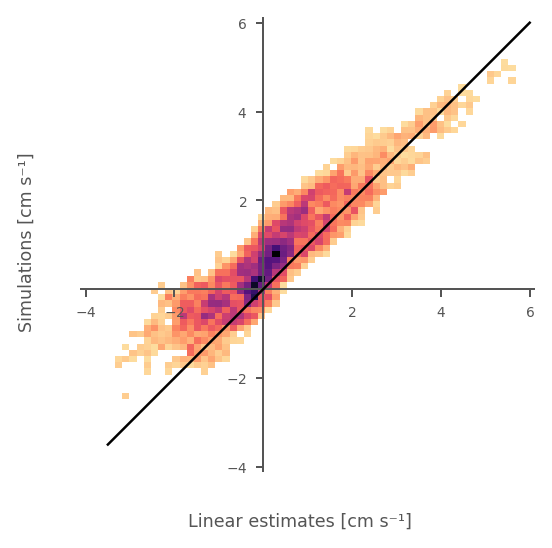

In [4]:
A4_filepath = "../output/processed/A4/"

# number of time steps
nt = 1895

# Define the basins and depths to be analyzed
basins = np.array(["canadian", "eurasian", "greenland", "norwegian"])
depths = np.array([2500, 2750, 3000, 3250, 3500, 3750])

# Initialize arrays to store circulation estimates and bottom circulation for each basin and depth
circulation_estimated = np.zeros((len(basins), len(depths), nt))
circulation_bottom = np.zeros((len(basins), len(depths), nt))

# Create an array of NaNs to handle missing data
tsnan = np.zeros(nt) * np.nan

# Loop through each basin and depth to extract circulation data
for i, basin in enumerate(basins):
    for j, depth in enumerate(depths):
        cfile = A4_filepath + f"{basin}_{depth}_100000_estimates.nc"
        
        if os.path.exists(cfile):
            data = xr.open_dataset(cfile)
            
            # Select the R value corresponding to the maximum correlation
            R = data.r.idxmax()
            ds = data.sel(R=R)
            
            # Store the estimated and bottom circulation values
            circulation_estimated[i, j, :] = ds.estimates.values
            circulation_bottom[i, j, :] = ds.circ_ub.values
        else:
            # Handle missing data by assigning NaN values
            circulation_estimated[i, j, :] = tsnan
            circulation_bottom[i, j, :] = tsnan

# Create a histogram plot to compare the distribution of estimated vs. simulated circulation
fig, ax = create_figure( "single", aspect_ratio=1)

# Flatten the arrays and convert to the appropriate units (cm/s)
x = circulation_estimated.flatten() * 1e2
y = circulation_bottom.flatten() * 1e2

# Remove NaN values from the flattened arrays
x = x[np.isfinite(x)]
y = y[np.isfinite(y)]

# Plot the joint histogram of estimated and simulated circulation values
sns.histplot(x=x, y=y, 
             bins=75, 
             pthresh=.1, 
             cmap="magma_r", 
             ax=ax,
             zorder=-2
             )

# Plot a reference line (y=x) to help assess the agreement between estimates and simulations
ax.plot((-3.5, 6), (-3.5, 6), color=palette["text"], zorder=12)

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal')

customize_axis(ax)

# Define the tick positions for the x and y axes
ax.set_yticks([-4, -2, 2, 4, 6])
ax.set_xticks([-4, -2, 2, 4, 6])

ax.set_xlim([-4.1, 6.1])
ax.set_ylim([-4.1, 6.1])

# Add labels to the figure
fig.supxlabel('Linear estimates [cm s⁻¹]', fontsize=7)
fig.supylabel('Simulations [cm s⁻¹]', fontsize=7)

fig.savefig(figpath + "A4_histogram.pdf")

## Domain

This figure summarizes the idealized shallow-water model geometry used throughout the paper. Panel (a) shows the bathymetry in plan view, including the depth contours used for contour-following diagnostics. Panel (b) shows the same bathymetry as a 3D surface to emphasize the slope geometry and the relationship between depth contours and the physical domain.

The highlighted contour indicates the mid-slope depth contour used for representative time-series diagnostics in later figures. The figure is saved as `bath_2d3d.pdf`.


In [5]:
X, Y, h = generate_bathymetry(default_params, full=True)

# m to km
X /= 1e3
Y /= 1e3
H_targets = np.mean(h, axis=1)

focus_j = 45

In [6]:
def plot_bathymetry(ax, X, Y, h):
    """
    Plot 2D bathymetry on a given axis using imshow (no contours).

    Parameters
    ----------
    ax : matplotlib axis object
    X, Y : 2D meshgrid arrays (in km)
    h : 2D array of bathymetry (in m, positive downward)
    """
    ax.set_aspect("equal")

    Z = h[::-1]  # transpose and flip y for correct orientation
    extent = [X.min(), X.max(), Y.min(), Y.max()]

    img = ax.imshow(
        Z,
        extent=extent,
        #origin="lower",  
        #cmap=cmo.deep,
        cmap = palette["cmseq"],
        vmin=100,#np.nanmin(h),
        vmax=900,#np.nanmax(h),
        aspect="auto"
    )

    ax.set_xlabel("x [km]")
    ax.set_ylabel("y [km]")

    ax.set_xticks(np.linspace(X.min(), X.max(), 4))
    ax.set_yticks(np.linspace(Y.min(), Y.max(), 4))

    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())

    return img

def add_bathymetry_contours(ax, X, Y, h, contours, color=colorwheel[0], linewidth=1):
    """
    Add bathymetry contours to an existing axis.
    """
    ax.contour(
        X, Y, h,
        levels=contours,
        colors=color,
        linewidths=linewidth
    )

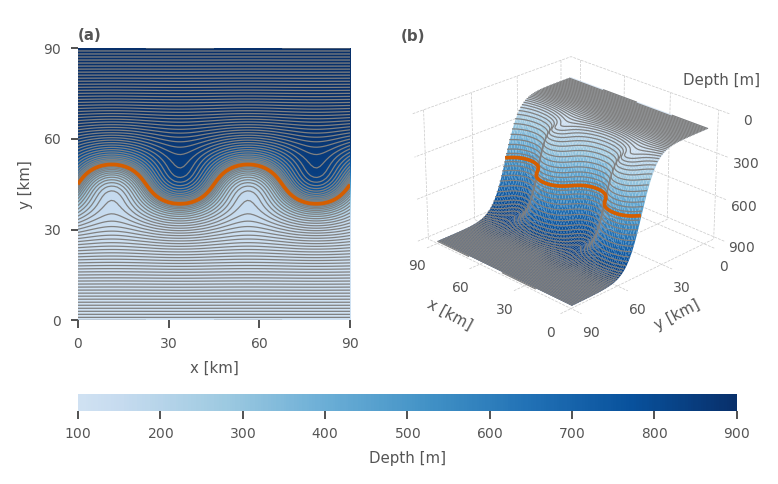

In [7]:
# --- Figure & layout: 2 panels (2D + 3D) ------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.6)

fig = plt.figure(figsize=(fig_width_in, fig_height_in))
gs = fig.add_gridspec(
    2, 2,
    height_ratios=[20, 1],   # big row for plots, small row for cbar
    width_ratios=[0.8, 1],
    hspace=0.25,
    wspace=0.15,
)

ax2d   = fig.add_subplot(gs[0, 0])
ax3d   = fig.add_subplot(gs[0, 1], projection="3d")
cbar_ax = fig.add_subplot(gs[1, :])   # spans both columns

# --- 2D bathymetry panel (left) ---------------------------------------------
# remove spines, keeping ticks
ax2d.spines['bottom'].set_visible(False)
ax2d.spines['left'].set_visible(False)

img = plot_bathymetry(ax2d, X, Y, h)

ax2d.set_aspect("equal")
add_bathymetry_contours(ax2d, X, Y, h, H_targets, color='gray', linewidth=0.5)
add_bathymetry_contours(ax2d, X, Y, h, [H_targets[focus_j]], color=colorwheel[2], linewidth=1.5)

ax2d.set_xlabel("x [km]")    # adjust to your labels
ax2d.set_ylabel("y [km]")


surf = ax3d.plot_surface(
    X, Y-0.5, h,
    cmap=img.cmap,
    norm=img.norm,
    rstride=1, cstride=1,
    linewidth=0,
    edgecolor='none',
    antialiased=True,
    shade=False,     # avoids faint geometrical artifacts
    alpha=1.0,
)


ax3d.contour(
    X, Y, h,
    levels=H_targets,
    colors='gray',
    linewidths=0.5,
)

ax3d.contour(
    X, Y, h,
    levels=H_targets[[focus_j, -1]],
    colors=[colorwheel[2], 'none'],   # real line + invisible dummy line (need two lines, bug?)
    linewidths=[1.5, 0]
)


# Make depth increase downward
ax3d.invert_zaxis()

# Camera angle (tweak as you like)
ax3d.view_init(elev=25, azim=135)

# Axis labels
ax3d.text3D(30, 150, 900, "x [km]", fontsize=6, zdir='x')
ax3d.text3D(-40, 80, 900, "y [km]", fontsize=6, zdir='y')
ax3d.text2D(0.85, 0.8, "Depth [m]", fontsize=6, transform=ax3d.transAxes)


# Reduce padding for x and y tick labels
ax3d.tick_params(axis='x', pad=-4)
ax3d.tick_params(axis='y', pad=-4)
ax3d.tick_params(axis='z', pad=-4)


# Make x and y equal, z 0.65 of that
ax3d.set_box_aspect((1, 1, 0.65))

# Clean up 3D look a bit
ax3d.xaxis.pane.set_alpha(0.0)
ax3d.yaxis.pane.set_alpha(0.0)
ax3d.zaxis.pane.set_alpha(0.0)
for axis in [ax3d.xaxis, ax3d.yaxis, ax3d.zaxis]:
    axis._axinfo["grid"]["linewidth"] = 0.3
    
# Set ticks 
ax3d.set_xticks([0,30,60,90])
ax3d.set_yticks([0,30,60,90])
ax3d.set_zticks([0,300,600,900])

# --- Horizontal shared colorbar (own axis in the mosaic) --------------------
cb = fig.colorbar(
    img,
    cax=cbar_ax,
    orientation="horizontal",
)
cb.outline.set_visible(False)
cb.ax.set_xlabel("Depth [m]", fontsize=6)



# remove spines
for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
    axis.line.set_visible(False)              # turn off main spine line
    axis._axinfo['tick']['inward_factor'] = 0
    axis._axinfo['tick']['outward_factor'] = 0


# add labels (a) and (b)
ax2d.text(0, 1.03, "(a)", transform=ax2d.transAxes,fontweight='bold')
ax3d.text2D(0, 0.931,"(b)", transform=ax3d.transAxes, fontweight='bold')

# --- Layout & export --------------------------------------------------------
#fig.tight_layout()
fig.savefig(figpath + "bath_2d3d.pdf")


## Circulation from a mid-slope depth contour

We next compare the circulation diagnosed along a representative mid-slope depth contour to the corresponding analytical estimate. 


### Scatter plots

The scatter plot aggregates the entire focus period and shows simulated circulation versus the linear estimate for the long- and short-period forcing cases. Deviations from the 1:1 line quantify the degree of nonlinearity and/or missing physics in the linear estimate.
The figure is saved as `scatterplots.pdf`.

In [8]:
ts_long = xr.open_dataset(datapath+"timeseries/analytical_estimates_long.nc")
ts_short = xr.open_dataset(datapath+"timeseries/analytical_estimates_short.nc")

ts_long

<xarray.Dataset>
Dimensions:             (time: 1024)
Coordinates:
  * time                (time) timedelta64[ns] 0 days 00:00:00 ... 127 days 2...
    j                   int32 ...
Data variables:
    circulation         (time) float64 ...
    linear_estimate     (time) float64 ...
    nonlinear_estimate  (time) float64 ...

In [9]:
def plot_scatter(ax, x, y, **kwargs):

    ax.scatter(x, y,
               color=colorwheel[2],
               zorder=-1,
               **kwargs
               )

    # # Plot a reference line (y=x) to help assess the agreement between estimates and simulations
    lmax = np.max(x)
    lmin = np.min(y)
    
    llim = np.max(np.abs(y))

    
    ax.plot(#(lmin, lmax), (lmin, lmax), 
            (-llim, llim), (-llim, llim),
            palette["text"],
            #lw=0.5,
            zorder=21,
            )

    customize_axis(ax)

    # Set the aspect ratio of the plot to be equal
    ax.set_aspect('equal')


def plot_circulation_timeseries(ax, ts):
    
    t = ts.time / np.timedelta64(1, "D")
    
    ax.plot(t, ts.circulation*1e2,
            color=colorwheel[0],#palette["accent1"],
            zorder=20,
            label = "Simulations"
            )
    
    ax.plot(t, ts.linear_estimate*1e2,
            color=colorwheel[1],#palette["accent2"],
            zorder=21,
            label="Linear estimates"
            )
    
    ax.plot(t, ts.nonlinear_estimate*1e2,
            color=colorwheel[2],#palette["accent3"],
            zorder=22,
            linestyle="--",
            label = "Estimates including\nrelative vorticity flux"
            )
    
    # Customize the axis appearance
    customize_axis(ax)

In [10]:
xL = ts_long.linear_estimate.values * 1e2
yL = ts_long.circulation.values * 1e2

xS = ts_short.linear_estimate.values * 1e2
yS = ts_short.circulation.values * 1e2

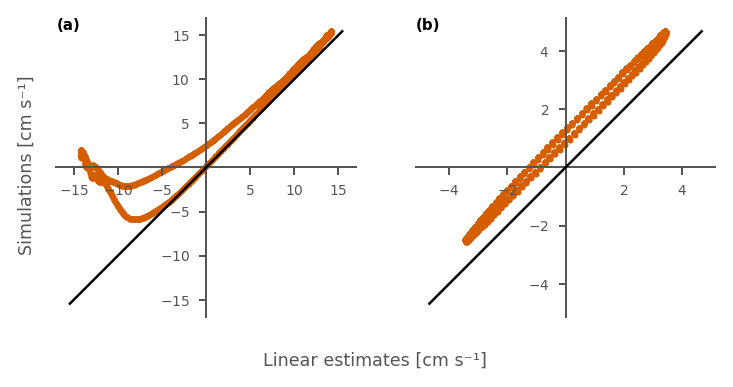

In [11]:
# scatter plot 
fig, [axL,axS] = create_figure(
    "double", ncols=2
    #"single", aspect_ratio=1.8, nrows=2
    )
plot_scatter(axL, xL, yL, s=2)
plot_scatter(axS, xS, yS, s=2)

fig.supxlabel('Linear estimates [cm s⁻¹]', 
              x=0.5, y=0.1, 
              fontsize=7
              )
fig.supylabel('Simulations [cm s⁻¹]', 
              x=0.08, y=0.5, 
              fontsize=7
              )

ticksL = [-15, -10, -5, 5, 10, 15]
axL.set_yticks(ticksL)
axL.set_xticks(ticksL)

ticksS = [-4, -2, 2, 4]
axS.set_yticks(ticksS)
axS.set_xticks(ticksS)

# add text annotation with subpanel label (a) and (b)
axL.text(0, 1, "(a)", color="black", 
         transform=axL.transAxes, 
         verticalalignment='top',
         fontweight='bold'
         )
axS.text(0, 1, "(b)", color="black",
         transform=axS.transAxes, 
         verticalalignment='top',
         fontweight='bold'
         )

#fig.set_constrained_layout(True)
fig.savefig(figpath+"scatterplots.pdf")


# Time series
We also plot the full time series for the same contour, including both the linear estimate and an extended estimate that includes relative vorticity fluxes. This figure highlights when the analytical estimates track the simulated response, and when offsets emerge.
The figure is saved as `timeseries_circulation.pdf`.


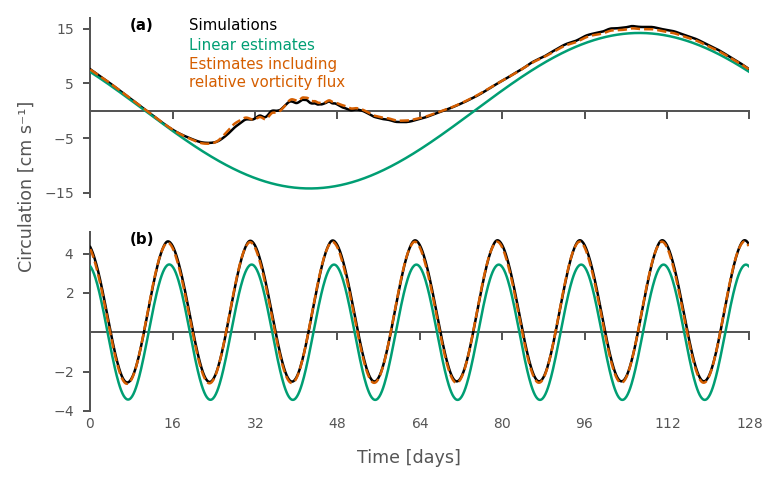

In [12]:

fig, [axt,axb] = create_figure("double", nrows=2, 
                               sharex =True
                               )

plot_circulation_timeseries(axt, ts_long)
plot_circulation_timeseries(axb, ts_short)

fig.supxlabel('Time [days]', 
              x=0.5, y=-0, 
              fontsize=7
              )
fig.supylabel('Circulation [cm s⁻¹]', 
              x=0.04, y=0.55, 
              fontsize=7,
              )

axt.set_yticks([-15, -5, 5, 15])
axb.set_yticks([-4, -2, 2, 4])
axb.set_xticks(np.arange(0, 129, 16))
axb.set_xlim([0, 128])

# Shift x-axis tick labels downward
for label in axb.get_xticklabels():
    label.set_y(label.get_position()[1] - 3.5)
    
# add labels (a) and (b)
axt.text(0.06, 1, "(a)", color="black",
         transform=axt.transAxes, 
         verticalalignment='top',       
         fontweight='bold'
         )
axb.text(0.06, 1, "(b)", color="black",
         transform=axb.transAxes, 
         verticalalignment='top',       
         fontweight='bold'
         )

labels = ["Simulations", "Linear estimates", "Estimates including\nrelative vorticity flux"]
y_start = 1
line_height = 0.1  # adjust for multi-line labels
y = y_start
for label, color in zip(labels, colorwheel):
    axt.text(
        0.15, y,
        label,
        color=color,
        #fontweight="bold",
        #fontsize=5,
        transform=axt.transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

fig.savefig(figpath+"timeseries_circulation.pdf")

## Base case momentum diagnostics along depth contours



### Depth contours

This figure shows the circulation and momentum balance expressed in the depth-following (constant-\(H\)) framework for the long- and short-period forcing cases. The main panel (ii) displays circulation as a function of time and contour index (shown as depth on the y-axis). Side panels summarize the momentum terms as (i) a time series along a representative mid-slope contour and (iii) a time-mean cross-slope structure over the selected focus region.

Terms shown are surface stress (SS), bottom stress (BS), and relative vorticity flux (RVF). The figure is saved as `Hmomentum.pdf`.

In [13]:
momentumpath_H = datapath+"momentum_terms_H/"
dsH_L = xr.open_dataset(momentumpath_H+"momentum_terms_H_long.nc")
dsH_S = xr.open_dataset(momentumpath_H+"momentum_terms_H_short.nc")

ystart = 20
ystop = 70

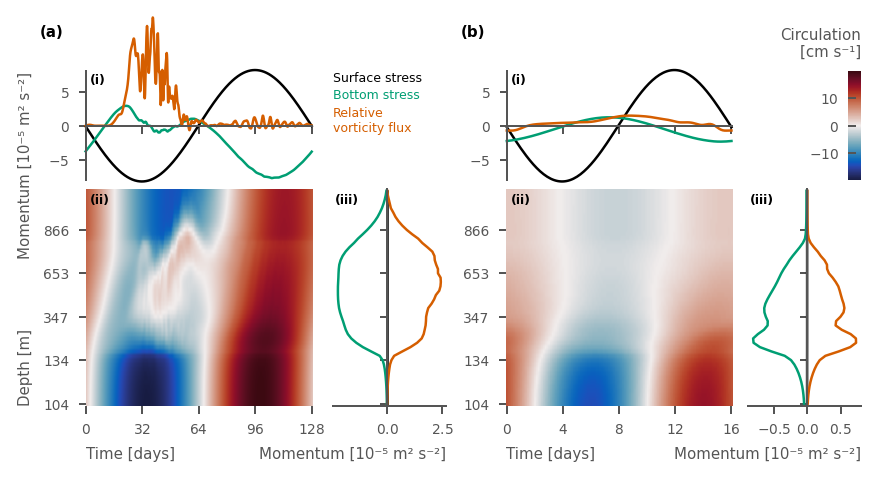

In [14]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.53)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic(
    [
        ["ymean_a", "legend_a", "ymean_b", "legend_b"],
        ["circ_a",  "tmean_a",  "circ_b",  "tmean_b"],
    ],
    gridspec_kw=dict(
        height_ratios=[2, 4],
        width_ratios=[4, 2, 4, 2],
    ),
)

# Share axes (avoid redundant ticks/labels)
axd["ymean_a"].sharey(axd["ymean_b"])
for sub in ("a", "b"):
    axd[f"tmean_{sub}"].sharey(axd[f"circ_{sub}"])
    axd[f"ymean_{sub}"].sharex(axd[f"circ_{sub}"])

# Axis cosmetics + remove redundant tick labels on shared axes
for sub in ("a", "b"):
    customize_axis(axd[f"tmean_{sub}"], yzero=False)
    customize_axis(axd[f"ymean_{sub}"])
    customize_axis(axd[f"legend_{sub}"], yzero=False)

    axd[f"tmean_{sub}"].tick_params(labelleft=False)  # shared y with circ_*
    axd[f"ymean_{sub}"].tick_params(labelbottom=False)  # shared x with circ_*
    
    # remove spines, keeping ticks
    axd[f"circ_{sub}"].spines['bottom'].set_visible(False)
    axd[f"circ_{sub}"].spines['left'].set_visible(False)

# Constrained layout paddings (set once)
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# --- LEFT PANEL (LONG) -------------------------------------------------------
# Data & grids
tdays_L  = dsH_L.time / np.timedelta64(1, "D")
equivY = Y[ystart:ystop,0]

# Color scale based on long run (you can also use both panels for vlim if desired)
vlim = np.max(np.abs(dsH_L.circulation * 1e2))

# Half-cell padding for imshow to match pcolormesh domain behavior
dt_L = np.diff(tdays_L).mean()
dy = np.diff(equivY).mean()

cm_a = axd["circ_a"].imshow(
    dsH_L.circulation.T * 1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_L[0] - dt_L/2, tdays_L[-1] + dt_L,
            equivY[0] - dy/2, equivY[-1] + dy/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# Optional for crisp PDF size: 
cm_a.set_rasterized(True)

# Y ticks & labels (equivalent-y line under depth)
axd["circ_a"].set_yticks(np.arange(20, 71, 10))
axd["circ_a"].set_yticklabels([f"{h:.0f}" for  h in (H_targets[ystart:ystop+1:10])])
axd["circ_a"].set_ylabel('Depth [m]', loc='bottom')
# axd["circ_a"].set_yticklabels([f"{h:.0f}\n/ {i*10+ystart}"
#                                for i, h in enumerate(H_targets[ystart:ystop+1:10])])
# axd["circ_a"].set_ylabel('Depth [m]\n/ Equivalent y [km]')
axd["circ_a"].set_xlabel('Time [days]', loc="left")
axd["circ_a"].set_xticks(np.arange(0, 129, 32))

# Lines for time-mean (tmean_a) and y-slice time series (ymean_a)
for i, term in enumerate(["SS", "BS", "RVF"]):
    # time-mean across the selected j-range
    tmean_L = dsH_L[term].mean("time") * 1e5
    axd["tmean_a"].plot(tmean_L, equivY, color=colorwheel[i])

    # one y-profile time series (here j=45)
    for j, ls in zip([45], ["-"]):
        yval_L = dsH_L[term].sel(j=j) *1e5
        axd["ymean_a"].plot(tdays_L, yval_L, color=colorwheel[i], ls=ls, clip_on=False)

    # stash labels for legend (in legend_a axis)
    axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# Legend (in its own axis)
axd["legend_a"].axis("off")
# axd["legend_a"].legend(
#     ["Surface\nstress", "Bottom\nstress", "Relative\nvorticity\nflux"],
#     loc="upper left", fontsize=5, frameon=False, bbox_to_anchor=(0, 1.3),
# )
labels = ["Surface stress", "Bottom stress", "Relative\nvorticity flux"]
y_start = 1
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axd["legend_a"].text(
        0.0, y,
        label,
        color=color,
        fontsize=5,
        transform=axd["legend_a"].transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries


# Axis labels for side panels
axd["ymean_a"].set_ylabel('Momentum [10⁻⁵ m² s⁻²]', loc='top')
axd["tmean_a"].set_xlabel('Momentum [10⁻⁵ m² s⁻²]', loc='right')


# --- RIGHT PANEL (SHORT) -----------------------------------------------------
tdays_S  = dsH_S.time / np.timedelta64(1, "D")
dt_S = np.diff(tdays_S).mean()

cm_b = axd["circ_b"].imshow(
    dsH_S.circulation.T * 1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S/2,
            equivY[0] - dy/2, equivY[-1] + dy/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# Optional: 
cm_b.set_rasterized(True)

# Y ticks (match left panel)
axd["circ_b"].set_yticks(np.arange(20, 71, 10))
axd["circ_b"].set_yticklabels([f"{h:.0f}" for  h in (H_targets[ystart:ystop+1:10])])
# axd["circ_b"].set_yticklabels([f"{h:.0f}\n/ {i*10+ystart}"
#                                for i, h in enumerate(H_targets[ystart:ystop+1:10])])
axd["circ_b"].set_xlabel('Time [days]', loc="left")
axd["circ_b"].set_xticks(np.arange(0, 17, 4))

# Time-mean and y-slice time series for short run
linestyles = [':', '--', '-']
for i, term in enumerate(["SS", "BS", "RVF"]):
    tmean_S = dsH_S[term].mean("time") * 1e5
    axd["tmean_b"].plot(tmean_S, equivY, color=colorwheel[i])

    for j, ls in zip([45], ["-"]):
        yval_S = dsH_S[term].sel(j=j) *1e5
        axd["ymean_b"].plot(tdays_S, yval_S, color=colorwheel[i], ls=ls, clip_on=False)

    axd["legend_b"].plot([None, None], [None, None], label=term, color=colorwheel[i])

axd["legend_b"].axis("off")

# --- Vertical colorbar in legend_b (right-aligned), using cm_a’s normalization ---
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(
    axd["legend_b"],
    width="12%",    # bar thickness (fraction of legend_b width)
    height="100%",  # bar length (fraction of legend_b height)
    loc="center right",
    borderpad=0.0
)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")  # ticks on the left (adjacent to panels)
cax.set_title("Circulation\n[cm s⁻¹]", loc="right", fontsize=6)  # label above bar

# Axis labels for side panels
axd["tmean_b"].set_xlabel('Momentum [10⁻⁵ m² s⁻²]', loc='right')

# Optional custom y-limits on ymean_b panel
axd['ymean_b'].set_ylim(-8, 8)


# --- Panel annotations --------------------------------------------------------
for sub in ('a', 'b'):
    for panel, text in zip(("ymean_", "circ_", "tmean_"), ("(i)", "(ii)", "(iii)")):
        axd[panel + sub].text(
            0.02, 0.98, text, color="black",
            transform=axd[panel + sub].transAxes,
            va='top', fontweight='bold', fontsize=5
        )
    axd["ymean_" + sub].text(
        -0.2, 1.43, f"({sub})", color="black",
        transform=axd["ymean_" + sub].transAxes,
        va='top', fontweight='bold', fontsize=6
    )

    
    
# Align any remaining shared labels (do this once, near the end)
fig.align_labels()

# --- Save --------------------------------------------------------------------
fig.savefig(figpath + "Hmomentum.pdf")


To complement the combined view, we plot the individual constant-\(H\) momentum terms as separate panels with a shared color scale. This makes it easier to compare the spatiotemporal imprint of each contribution between long and short forcing periods.
The figure is saved as `Hmomentum_terms.pdf`.

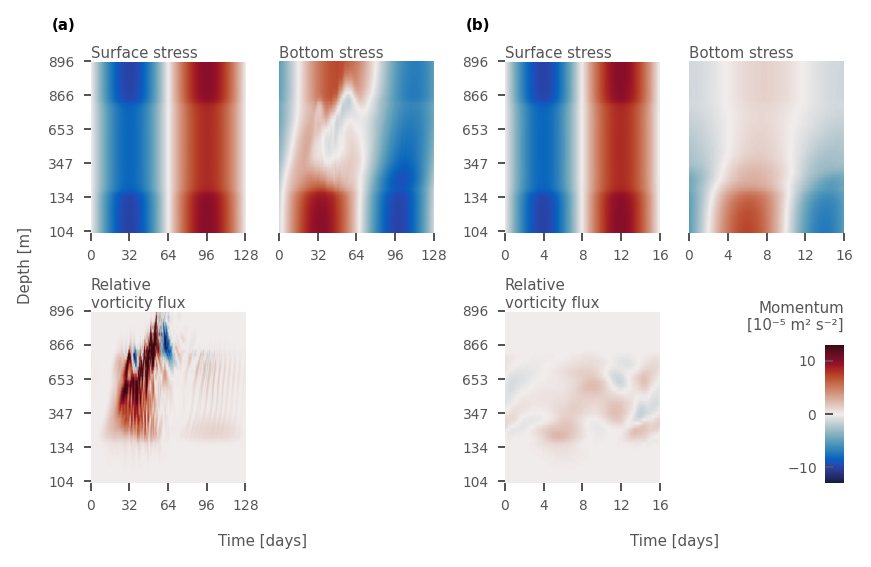

In [15]:
# Individual momentum terms 

# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.6)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

# 2 subfigures (a,b) stacked; 3 panels each; one shared colorbar to the far right
axd = fig.subplot_mosaic(
    [
        ["a0", "a1", "b0", "b1"],
        ["a2", "aC", "b2", "cb"],  # aC is just an empty spacer
    ],
    gridspec_kw=dict(
        width_ratios=[1,1,1, 1],
        height_ratios=[1, 1],
    ),
)

for key, ax in axd.items():
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
# --- Data prep ---------------------------------------------------------------
# Left / long (subfigure a)
terms = ["SS", "BS", "RVF"]
names = ["Surface stress", "Bottom stress", "Relative\nvorticity flux"]


# One shared color scale across ALL panels (98th pct of abs across both subfigures)
vmax = np.nanmax([
    *[np.abs(dsH_L[term]).quantile(0.98) for term in terms],
    *[np.abs(dsH_S[term]).quantile(0.98) for term in terms],
]) * 1e5
vmin = -vmax

# --- Helpers: imshow with half-cell padding ---------------------------------
def _imshow(ax, Z, x, y, vmin, vmax, cmap):
    import numpy as np
    x = np.asarray(x); y = np.asarray(y)
    dx = np.diff(x).mean() if x.size > 1 else 1.0
    dy = np.diff(y).mean() if y.size > 1 else 1.0
    return ax.imshow(
        Z, origin="lower", aspect="auto",
        extent=[x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2],
        vmin=vmin, vmax=vmax, cmap=cmap
    )

# --- Subfigure (a): long -----------------------------------------------------
axes_a = [axd["a0"], axd["a1"], axd["a2"]]
for term, ax, name in zip(terms, axes_a, names):
    cm_a = _imshow(
        ax,
        dsH_L[term].T * 1e5,
        tdays_L, equivY,
        vmin, vmax, palette["cmdiv"]
    )
    ax.text(0.0, 1.0, name, ha="left", va="bottom", transform=ax.transAxes)
    ax.set_xticks(np.arange(0, 129, 32))

# y-ticks & dual labels on first and third panels
for key in ("a0", "a2"):
    axd[key].set_yticks(np.arange(20, 71, 10))
    axd[key].set_yticklabels([f"{h:.0f}" for h in H_targets[ystart:ystop+1:10]])

# hide redundant y-ticks on middle panel; turn spacer off
axd["a1"].set_yticks([])
axd["aC"].axis("off")

# --- Subfigure (b): short ----------------------------------------------------
axes_b = [axd["b0"], axd["b1"], axd["b2"]]
for term, ax, name in zip(terms, axes_b, names):
    cm_b = _imshow(
        ax,
        dsH_S[term].T * 1e5,
        tdays_S, equivY,
        vmin, vmax, palette["cmdiv"]
    )
    ax.text(0.0, 1.0, name, ha="left", va="bottom", transform=ax.transAxes)
    ax.set_xlim(0, 16)
    ax.set_xticks(np.arange(0, 17, 4))

for key in ("b0", "b2"):
    axd[key].set_yticks(np.arange(20, 71, 10))
    axd[key].set_yticklabels([f"{h:.0f}" for h in H_targets[ystart:ystop+1:10]])

axd["b1"].set_yticks([])
#axd["bC"].axis("off")

# --- Labels & titles ---------------------------------------------------------
#fig.supxlabel("Time [days]")
fig.supylabel("Depth [m]", fontsize=6)

axd["a0"].text(-0.25, 1.25, "(a)", color="black",
               transform=axd["a0"].transAxes,
               va="top", fontweight="bold")
axd["b0"].text(-0.25, 1.25, "(b)", color="black",
               transform=axd["b0"].transAxes,
               va="top", fontweight="bold")

# --- Shared colorbar (far right, bottom) -----------------------
axd["cb"].axis("off")

cax = inset_axes(
    axd["cb"],
    width="12%",    # bar thickness (fraction of legend_b width)
    height="80%",  # bar length (fraction of legend_b height)
    loc="lower right",
    borderpad=0.0
)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")#, label="Momentum [10⁻⁵ m² s⁻²]")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")  # ticks on the left (adjacent to panels)
#cbar.ax.yaxis.set_label_position("left")
cbar.ax.set_title("Momentum\n[10⁻⁵ m² s⁻²]", loc="right", fontsize=6)  # label above bar

# --- Final touches & save ----------------------------------------------------
# ensure imshows don't get squashed in PDF
for key in ("a0","a1","a2","b0","b1","b2"):
    axd[key].set_aspect("auto", adjustable="box")

fig.canvas.draw()

def add_group_xlabel(keys, text, dy=0.1):
    # compute group bounds in figure fraction coords
    x0s, x1s, y0s = [], [], []
    for k in keys:
        pos = axd[k].get_position()
        x0s.append(pos.x0); x1s.append(pos.x1); y0s.append(pos.y0)
    xc = (min(x0s) + max(x1s)) / 2.0      # center of group
    y  = min(y0s) - dy                     # a bit below the lowest panel
    fig.text(xc, y, text, ha="center", va="top")

# one label under subfigure (a), and one under subfigure (b)
add_group_xlabel(["a0","a1","a2"], "Time [days]")
add_group_xlabel(["b0","b1","b2"], "Time [days]")

fig.savefig(figpath + "Hmomentum_terms.pdf")  # no bbox_inches with constrained layout


## Momentum diagrams on constant $y$ contours## Momentum diagnostics on constant-\(y\) transects

We repeat the momentum-budget visualization in Cartesian coordinates (constant \(y\)). The layout mirrors the constant-\(H\) figure: circulation as a function of time and \(y\) in the main panel, with side panels showing the domain-mean time series and the time-mean cross-slope structure.

Terms shown are surface stress (SS), bottom stress (BS), momentum flux convergence (MFC), and topographic form stress (TFS). The figure is saved as `Ymomentum.pdf`.


In [16]:
dsY_L = xr.open_dataset(datapath+"momentum_terms_y/momentum_terms_y_long.nc")
dsY_S = xr.open_dataset(datapath+"momentum_terms_y/momentum_terms_y_short.nc")

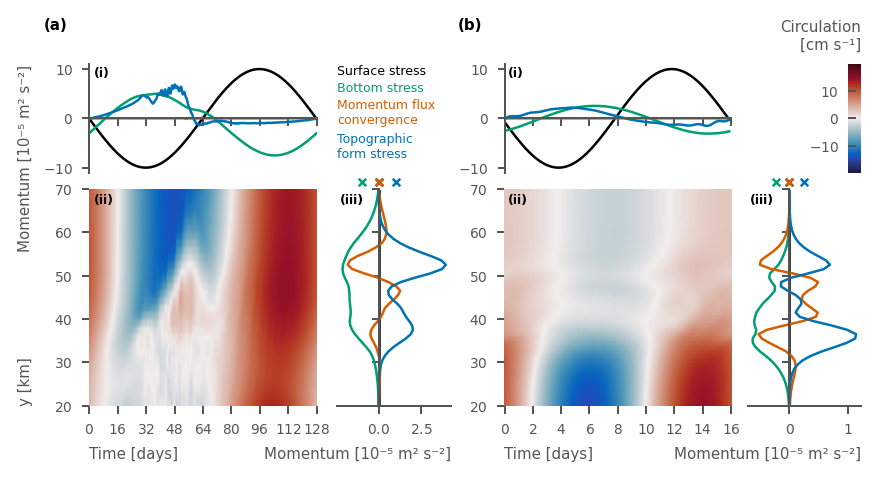

In [17]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.53)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic(
    [
        ["ymean_a", "legend_a", "ymean_b", "legend_b"],
        ["circ_a",  "tmean_a",  "circ_b",  "tmean_b"],
    ],
    gridspec_kw=dict(
        height_ratios=[2, 4],
        width_ratios=[4, 2, 4, 2],
    ),
)

# Share axes (avoid redundant ticks/labels)
axd["ymean_a"].sharey(axd["ymean_b"])
for sub in ("a", "b"):
    axd[f"tmean_{sub}"].sharey(axd[f"circ_{sub}"])
    axd[f"ymean_{sub}"].sharex(axd[f"circ_{sub}"])

# Cosmetics & shared tick label suppression
for sub in ("a", "b"):
    customize_axis(axd[f"tmean_{sub}"], yzero=False)
    customize_axis(axd[f"ymean_{sub}"])
    customize_axis(axd[f"legend_{sub}"], yzero=False)
    axd[f"tmean_{sub}"].tick_params(labelleft=False)   # shared y with circ_*
    axd[f"ymean_{sub}"].tick_params(labelbottom=False) # shared x with circ_*
    
    # remove spines, keeping ticks
    axd[f"circ_{sub}"].spines['bottom'].set_visible(False)
    axd[f"circ_{sub}"].spines['left'].set_visible(False)

# Constrained layout padding
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# --- Data prep & common color scale -----------------------------------------
# Left (long)
tdays_L  = dsY_L.time / np.timedelta64(1, "D")
Y_L      = dsY_L.yC / 1e3

# Right (short) slice & re-zero its own time
tdays_S  = dsY_S.time / np.timedelta64(1, "D")
Y_S      = dsY_S.yC / 1e3

# Unified vlim across panels (so colors are comparable)
vlim = np.nanmax([
    np.abs(dsY_L.circulation).max(),
    np.abs(dsY_S.circulation).max(),
])*1e2


# --- LEFT PANEL (LONG) -------------------------------------------------------
# Half-cell padding so ticks at the ends show up with imshow
dt_L = np.diff(tdays_L).mean()
dy_L = np.diff(Y_L).mean()

cm_a = axd["circ_a"].imshow(
    dsY_L.isel(yC=slice(ystart, ystop)).circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_L[0] - dt_L/2, tdays_L[-1] + dt_L, Y_L[0] - dy_L/2, Y_L[-1] + dy_L/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# Optional for lightweight PDFs
# cm_a.set_rasterized(True)

# Ticks & labels
axd["circ_a"].set_xticks(np.arange(0, 129, 16))
axd["circ_a"].set_yticks(np.arange(20, 71, 10))
axd["circ_a"].set_xlabel("Time [days]", loc="left")
axd["circ_a"].set_ylabel("y [km]", loc="bottom")

# Lines: time-mean (over time) vs Y, and y-mean (over Y) vs time
for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_L = dsY_L[term].mean("time") * 1e5
    axd["tmean_a"].plot(tmean_L, Y_L, color=colorwheel[i])

    ymean_L = dsY_L[term].mean("yC") * 1e5
    axd["ymean_a"].plot(tdays_L, ymean_L, color=colorwheel[i])

    # Marker at y-mean of the time series (placed slightly above the top)
    ytmean_L = ymean_L.mean("time")
    axd["tmean_a"].scatter(ytmean_L, Y_L[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    # Collect legend handles in its own axis
    axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# Legend (left legend axis)
axd["legend_a"].axis("off")
# axd["legend_a"].legend(
#     ["SS", "BS", "MFC", "TFS"],
#     loc="upper left", frameon=False, fontsize=5, bbox_to_anchor=(0, 1.15)
# )
labels = ["Surface stress", "Bottom stress", "Momentum flux\nconvergence", "Topographic\nform stress"]
y_start = 1
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axd["legend_a"].text(
        0.0, y,
        label,
        color=color,
        fontsize=5,
        transform=axd["legend_a"].transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

# Axes labels for side panels
axd["ymean_a"].set_ylabel("Momentum [10⁻⁵ m² s⁻²]", loc="top")
axd["tmean_a"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")


# --- RIGHT PANEL (SHORT) -----------------------------------------------------
dt_S = np.diff(tdays_S).mean()
dy_S = np.diff(Y_S).mean()

cm_b = axd["circ_b"].imshow(
    dsY_S.circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S, Y_S[0] - dy_S/2, Y_S[-1] + dy_S/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# cm_b.set_rasterized(True)

axd["circ_b"].set_xticks(np.arange(0, 17, 2))
axd["circ_b"].set_yticks(np.arange(20, 71, 10))
axd["circ_b"].set_xlabel("Time [days]", loc="left")

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_S = dsY_S[term].mean("time") * 1e5
    axd["tmean_b"].plot(tmean_S, Y_S, color=colorwheel[i])

    ymean_S = dsY_S[term].mean("yC") * 1e5
    axd["ymean_b"].plot(tdays_S, ymean_S, color=colorwheel[i])

    ytmean_S = ymean_S.mean("time")
    axd["tmean_b"].scatter(ytmean_S, Y_S[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    axd["legend_b"].plot([None, None], [None, None], label=term, color=colorwheel[i])

axd["legend_b"].axis("off")

# Colorbar in legend_b, sharing cm_a normalization
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax = inset_axes(axd["legend_b"], width="12%", height="100%", loc="center right", borderpad=0.0)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")
cax.set_title("Circulation\n[cm s⁻¹]", fontsize=6, loc="right")

# Axes labels for side panels
axd["tmean_b"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")
axd["tmean_a"].set_ylim(ystart, ystop)  # lock tmean ranges to panel height
axd["tmean_b"].set_ylim(ystart, ystop)

# --- Panel annotations --------------------------------------------------------
for sub in ("a", "b"):
    for panel, text in zip(("ymean_", "circ_", "tmean_"), ("(i)", "(ii)", "(iii)")):
        axd[panel + sub].text(
            0.02, 0.98, text, color="black",
            transform=axd[panel + sub].transAxes,
            va="top", fontweight="bold", fontsize=5
        )
    axd["ymean_" + sub].text(
        -0.2, 1.43, f"({sub})", color="black",
        transform=axd["ymean_" + sub].transAxes,
        va="top", fontweight="bold", fontsize=6
    )

# Align any remaining shared labels (once, near the end)
fig.align_labels()

# --- Save --------------------------------------------------------------------
fig.savefig(figpath + "Ymomentum.pdf")


We also plot the individual constant-\(y\) momentum terms as separate panels with a shared color scale across both forcing periods. 
The figure is saved as `Ymomentum_terms.pdf`.


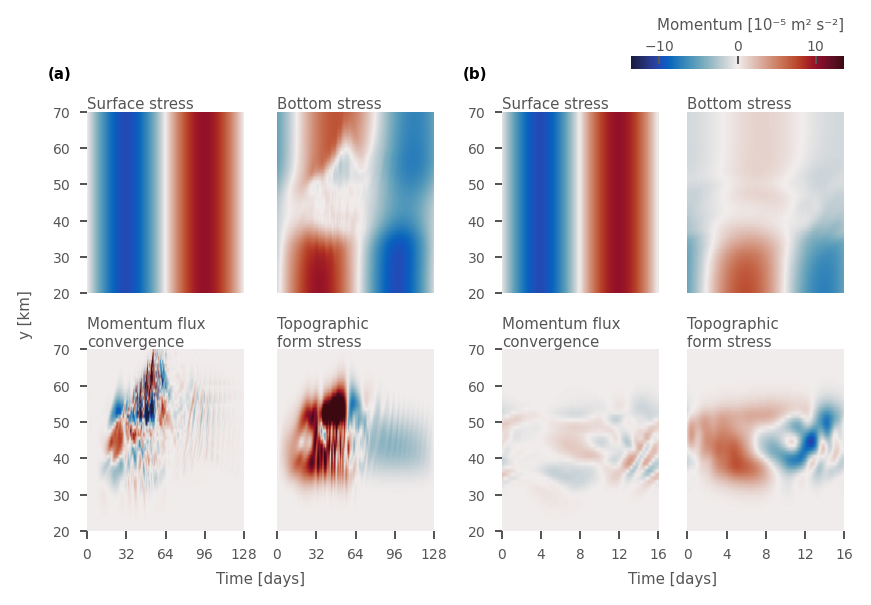

In [18]:
# Individual momentum terms
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.6)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

# 2 subfigures (a,b) side-by-side groups, each with 2x2 panels; no colorbar
axd = fig.subplot_mosaic(
    [
        ["a0", "a1", "b0", "b1"],
        ["a2", "a3", "b2", "b3"],
    ],
    gridspec_kw=dict(width_ratios=[1, 1, 1, 1], height_ratios=[1, 1]),
)

# Clean spines (match your style)
for ax in axd.values():
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

# --- Data prep ---------------------------------------------------------------
terms = ["SS", "BS", "MFC", "TFS"]
names = ["Surface stress", "Bottom stress", "Momentum flux\nconvergence", "Topographic\nform stress"]

# (a) long
tdays_L = dsY_L.time / np.timedelta64(1, "D")
Y_L     = dsY_L.yC / 1e3

# (b) short (time re-zeroed)
tdays_S = dsY_S.time / np.timedelta64(1, "D")
Y_S     = dsY_S.yC / 1e3

# Shared symmetric color scale via 98th percentile across BOTH subfigures
vmax = np.nanmax([
    *[np.abs(dsY_L[term]).quantile(0.98) for term in terms],
    *[np.abs(dsY_S[term]).quantile(0.98) for term in terms],
]) * 1e5
vmin = -vmax

# --- Helper: imshow with half-cell padding ----------------------------------
def _imshow(ax, Z, x, y, vmin, vmax, cmap):
    x = np.asarray(x); y = np.asarray(y)
    dx = np.diff(x).mean() if x.size > 1 else 1.0
    dy = np.diff(y).mean() if y.size > 1 else 1.0
    return ax.imshow(
        Z, origin="lower", aspect="auto",
        extent=[x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2],
        vmin=vmin, vmax=vmax, cmap=cmap
    )

# --- Subfigure (a): four panels ----------------------------------------------
axes_a = [axd["a0"], axd["a1"], axd["a2"], axd["a3"]]
for term, ax, name in zip(terms, axes_a, names):
    cm_a = _imshow(
        ax,
        dsY_L[term].T * 1e5,
        tdays_L, Y_L, vmin, vmax, palette["cmdiv"]
    )
    ax.text(0.0, 1.0, name, ha="left", va="bottom", transform=ax.transAxes)
# ticks: hide x on top row, hide y on right col
for key in ("a0", "a1"): axd[key].set_xticks([])
for key in ("a1", "a3"): axd[key].set_yticks([])
# bottom row x ticks/limits
for key in ("a2", "a3"):
    axd[key].set_xticks(np.arange(0, 129, 32))
# y ticks on left column
for key in ("a0", "a2"):
    axd[key].set_yticks(np.arange(20, 71, 10))

# --- Subfigure (b): four panels ----------------------------------------------
axes_b = [axd["b0"], axd["b1"], axd["b2"], axd["b3"]]
for term, ax, name in zip(terms, axes_b, names):
    cm_b = _imshow(
        ax,
        dsY_S[term].T * 1e5,
        tdays_S, Y_S, vmin, vmax, palette["cmdiv"]
    )
    ax.text(0.0, 1.0, name, ha="left", va="bottom", transform=ax.transAxes)
# ticks: hide x on top row, hide y on right col
for key in ("b0", "b1"): axd[key].set_xticks([])
for key in ("b1", "b3"): axd[key].set_yticks([])
# bottom row x ticks/limits (0–16 days)
for key in ("b2", "b3"):
    axd[key].set_xlim(0, 16)
    axd[key].set_xticks(np.arange(0, 17, 4))
# y ticks on left column
for key in ("b0", "b2"):
    axd[key].set_yticks(np.arange(20, 71, 10))

# --- Subfigure labels & group x-labels ---------------------------------------
axd["a0"].text(-0.25, 1.25, "(a)", color="black",
               transform=axd["a0"].transAxes, va="top", fontweight="bold")
axd["b0"].text(-0.25, 1.25, "(b)", color="black",
               transform=axd["b0"].transAxes, va="top", fontweight="bold")

fig.supylabel("y [km]", fontsize=6)

# finalize layout so positions are accurate for group xlabels
fig.canvas.draw()

def add_group_xlabel(keys, text, dy=0.08):
    x0s, x1s, y0s = [], [], []
    for k in keys:
        pos = axd[k].get_position()
        x0s.append(pos.x0); x1s.append(pos.x1); y0s.append(pos.y0)
    xc = (min(x0s) + max(x1s)) / 2.0
    y  = min(y0s) - dy
    fig.text(xc, y, text, ha="center", va="top")

# one label under subfigure (a), and one under subfigure (b)
add_group_xlabel(["a0", "a1", "a2", "a3"], "Time [days]")
add_group_xlabel(["b0", "b1", "b2", "b3"], "Time [days]")

# --- Final touches & save ----------------------------------------------------
for key in ("a0","a1","a2","a3","b0","b1","b2","b3"):
    axd[key].set_aspect("auto", adjustable="box")

fig.canvas.draw()


# --- Add horizontal colorbar in the top-right corner -------------------------
# Define position in figure coordinates (fractions)
cbar_width  = 0.25   # fraction of figure width
cbar_height = 0.025  # fraction of figure height
cbar_x0     = 0.73   # move right to align above subfigure (b)
cbar_y0     = 0.98   # just above top panels

# Create new axis for colorbar
cax = fig.add_axes([cbar_x0, cbar_y0, cbar_width, cbar_height])

# Create the colorbar from cm_a (shared normalization)
cbar = fig.colorbar(cm_a, cax=cax, orientation="horizontal")

# --- Style tweaks ---
cbar.ax.tick_params(direction="in", top=True, bottom=False, pad=1)
cbar.outline.set_visible(False)
cbar.ax.xaxis.set_ticks_position("top")   # ticks on top
cbar.ax.xaxis.set_label_position("top")   # label above bar
cbar.set_label("Momentum [10⁻⁵ m² s⁻²]", loc="right")

fig.savefig(figpath + "Ymomentum_terms.pdf", bbox_inches="tight", pad_inches=0.02)


## Comparing QGPV-flux diagnostics across contour frameworks

Here we compare the momentum-balance contributions associated with potential-vorticity fluxes across the constant-\(y\) and constant-\(H\) frameworks. Solid lines show time-mean terms diagnosed on constant-\(y\) transects, while dashed lines show the corresponding depth-contour diagnostics.

In the constant-\(y\) framework we use the sum of momentum flux convergence and topographic form stress (MFC + TFS) as a proxy for the net PV-related contribution, and compare it to the relative vorticity flux (RVF) diagnosed along depth contours. The figure is saved as `PVflux.pdf`.


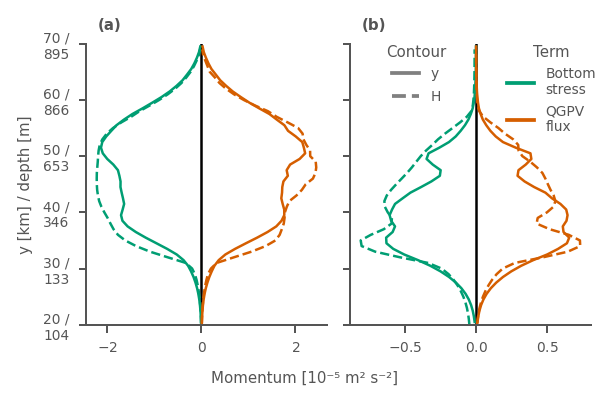

In [19]:
(fig_width_in, fig_height_in), _ = get_figure_dimensions("single", aspect_ratio=0.65)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic([["long", "short"]], sharey=True)

for ax in axd.values():
    ax.axvline(0, color="black")
    #customize_axis(ax, yzero=False)

yticks = np.arange(20, 71, 10)
ax = axd["long"]
ax.set_yticks(yticks)
ax.set_ylim(ystart, ystop)

# corresponding depth values
depths = H_targets[ystart:ystop+1:10]

# safety check: lengths must match
assert len(yticks) == len(depths)

# build labels
yticklabels = [f"{y:.0f} /\n{int(H)}" for y, H in zip(yticks, depths)]
ax.set_yticklabels(yticklabels)

# ylabel
ax.set_ylabel("y [km] / depth [m]")

fig.supxlabel("Momentum [10⁻⁵ m² s⁻²]", fontsize=6)

SCALE = 1e5

cases = {
    "long": dict(ax=axd["long"], dsY=dsY_L, dsH=dsH_L, Y=Y_L, YH=equivY),
    "short": dict(ax=axd["short"], dsY=dsY_S, dsH=dsH_S, Y=Y_S, YH=equivY),
}

def _plot_case(case, term, color):
    ax, dsY, dsH = case["ax"], case["dsY"], case["dsH"]
    Y, YH = case["Y"], case["YH"]

    if term == "sum":
        #yterm = dsY["QGPVF"] 
        yterm = dsY["TFS"] + dsY["MFC"]
        hterm = dsH["RVF"]
    else:
        yterm = dsY[term]
        hterm = dsH[term]

    ax.plot(yterm.mean("time") * SCALE, Y,  color=color)
    ax.plot(hterm.mean("time") * SCALE, YH, color=color, ls="--")

for i, term in enumerate(("BS", "sum")):
    col = colorwheel[i+1]
    for case in cases.values():
        _plot_case(case, term, col)
        
# add labels (a) and (b)
axd["long"].text(0.05, 1.05, "(a)", transform=axd["long"].transAxes,fontweight='bold')
axd["short"].text(0.05, 1.05,"(b)", transform=axd["short"].transAxes, fontweight='bold')


# --- Legends ---
# Color legend (terms)
term_handles = [
    Line2D([0], [0], color=colorwheel[1], lw=1.5, label="Bottom\nstress"),
    Line2D([0], [0], color=colorwheel[2], lw=1.5, label="QGPV\nflux"),
]

# Line-style legend (diagnostic framework; grey only)
framework_handles = [
    Line2D([0], [0], color="grey", lw=1.5, ls="-",  label=r"$y$"),
    Line2D([0], [0], color="grey", lw=1.5, ls="--", label=r"$H$"),
]

ax0 = axd["short"]  # anchor both legends to left panel

leg_terms = ax0.legend(
    handles=term_handles, title="Term", 
    frameon=False, loc="upper left", bbox_to_anchor=(0.6, 1.04)
)
leg_framework = ax0.legend(
    handles=framework_handles, title="Contour",
    frameon=False, loc="upper left", bbox_to_anchor=(0.1, 1.04)
)
ax0.add_artist(leg_terms)
fig.savefig(figpath + "PVflux.pdf")

## Smooth-slope comparison: no corrugations

To isolate the role of corrugations, we repeat the constant-\(y\) momentum-budget visualization for smooth-slope simulations (“no bumps”). We compare two short-period cases: one with purely along-slope forcing and one with an additional cross-slope forcing component.

The layout is identical to the base-case constant-\(y\) figure, enabling direct visual comparison of circulation variability and term balances. The figure is saved as `Ymomentums_nobumps.pdf`.


In [20]:
## No bumps
dsY_L_nb = xr.open_dataset(datapath+"momentum_terms_y/momentum_terms_y_long_nobumps.nc")
dsY_S_nb = xr.open_dataset(datapath+"momentum_terms_y/momentum_terms_y_short_nobumps.nc")
dsY_L_nb_cw = xr.open_dataset(datapath+"momentum_terms_y/momentum_terms_y_long_nobumps_crosswind.nc")
dsY_S_nb_cw = xr.open_dataset(datapath+"momentum_terms_y/momentum_terms_y_short_nobumps_crosswind.nc")


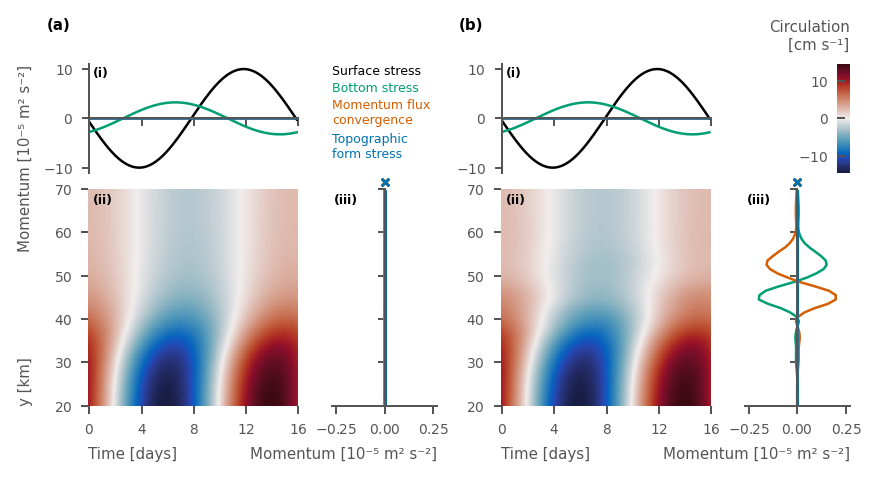

In [21]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.53)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic(
    [
        ["ymean_a", "legend_a", "ymean_b", "legend_b"],
        ["circ_a",  "tmean_a",  "circ_b",  "tmean_b"],
    ],
    gridspec_kw=dict(
        height_ratios=[2, 4],
        width_ratios=[4, 2, 4, 2],
    ),
)

# Share axes (avoid redundant ticks/labels)
axd["ymean_a"].sharey(axd["ymean_b"])
for sub in ("a", "b"):
    axd[f"tmean_{sub}"].sharey(axd[f"circ_{sub}"])
    axd[f"ymean_{sub}"].sharex(axd[f"circ_{sub}"])

# Cosmetics & shared tick label suppression
for sub in ("a", "b"):
    customize_axis(axd[f"tmean_{sub}"], yzero=False)
    customize_axis(axd[f"ymean_{sub}"])
    customize_axis(axd[f"legend_{sub}"], yzero=False)
    axd[f"tmean_{sub}"].tick_params(labelleft=False)   # shared y with circ_*
    axd[f"ymean_{sub}"].tick_params(labelbottom=False) # shared x with circ_*
    
    # remove spines, keeping ticks
    axd[f"circ_{sub}"].spines['bottom'].set_visible(False)
    axd[f"circ_{sub}"].spines['left'].set_visible(False)

# Constrained layout padding
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# --- Data prep & common color scale -----------------------------------------
tdays_S  = dsY_S_nb.time / np.timedelta64(1, "D")
Y_S      = dsY_S_nb.yC / 1e3

# Unified vlim across panels (so colors are comparable)
vlim = np.nanmax([
    np.abs(dsY_S_nb_cw.circulation).max(),
    np.abs(dsY_S_nb.circulation).max(),
])*1e2


# --- LEFT PANEL (regular) -------------------------------------------------------
# Half-cell padding so ticks at the ends show up with imshow
cm_a = axd["circ_a"].imshow(
    dsY_S_nb.circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S, Y_S[0] - dy_S/2, Y_S[-1] + dy_S/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# Optional for lightweight PDFs
# cm_a.set_rasterized(True)

# Ticks & labels
axd["circ_a"].set_xticks(np.arange(0, 17, 4))
axd["circ_a"].set_yticks(np.arange(20, 71, 10))
axd["circ_a"].set_xlabel("Time [days]", loc="left")
axd["circ_a"].set_ylabel("y [km]", loc="bottom")

# Lines: time-mean (over time) vs Y, and y-mean (over Y) vs time
for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_S = dsY_S_nb[term+"y"]* 1e5
    axd["tmean_a"].plot(tmean_S, Y_S, color=colorwheel[i])

    ymean_S = dsY_S_nb[term+"t"] * 1e5
    axd["ymean_a"].plot(tdays_S, ymean_S, color=colorwheel[i])

    # Marker at y-mean of the time series (placed slightly above the top)
    ytmean_S = ymean_S.mean("time")
    axd["tmean_a"].scatter(ytmean_S, Y_S[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    # Collect legend handles in its own axis
    axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# Legend (left legend axis)
axd["legend_a"].axis("off")
# axd["legend_a"].legend(
#     ["SS", "BS", "MFC", "TFS"],
#     loc="upper left", frameon=False, fontsize=5, bbox_to_anchor=(0, 1.15)
# )
labels = ["Surface stress", "Bottom stress", "Momentum flux\nconvergence", "Topographic\nform stress"]
y_start = 1
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axd["legend_a"].text(
        0.0, y,
        label,
        color=color,
        fontsize=5,
        transform=axd["legend_a"].transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

# Axes labels for side panels
axd["ymean_a"].set_ylabel("Momentum [10⁻⁵ m² s⁻²]", loc="top")
axd["tmean_a"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")


# --- RIGHT PANEL (cross-slope) -----------------------------------------------------
cm_b = axd["circ_b"].imshow(
    dsY_S_nb_cw.circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S, Y_S[0] - dy_S/2, Y_S[-1] + dy_S/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# cm_b.set_rasterized(True)

axd["circ_b"].set_xticks(np.arange(0, 17, 4))
axd["circ_b"].set_yticks(np.arange(20, 71, 10))
axd["circ_b"].set_xlabel("Time [days]", loc="left")

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_S = dsY_S_nb_cw[term+"y"] * 1e5
    axd["tmean_b"].plot(tmean_S, Y_S, color=colorwheel[i])

    ymean_S = dsY_S_nb_cw[term+"t"] * 1e5
    axd["ymean_b"].plot(tdays_S, ymean_S, color=colorwheel[i])

    ytmean_S = ymean_S.mean("time")
    axd["tmean_b"].scatter(ytmean_S, Y_S[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    axd["legend_b"].plot([None, None], [None, None], label=term, color=colorwheel[i])

axd["legend_b"].axis("off")

# Colorbar in legend_b, sharing cm_a normalization
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax = inset_axes(axd["legend_b"], width="12%", height="100%", loc="center right", borderpad=0.0)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")
cax.set_title("Circulation\n[cm s⁻¹]", fontsize=6, loc="right")

# Axes labels for side panels
axd["tmean_b"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")

# Set x-limits to match momentum ranges 
axd["tmean_a"].set_xlim(-0.27, 0.27) 
axd["tmean_b"].set_xlim(-0.27, 0.27) 

axd["tmean_a"].set_ylim(ystart, ystop)  # lock tmean ranges to panel height
axd["tmean_b"].set_ylim(ystart, ystop)

# --- Panel annotations --------------------------------------------------------
for sub in ("a", "b"):
    for panel, text in zip(("ymean_", "circ_", "tmean_"), ("(i)", "(ii)", "(iii)")):
        axd[panel + sub].text(
            0.02, 0.98, text, color="black",
            transform=axd[panel + sub].transAxes,
            va="top", fontweight="bold", fontsize=5
        )
    axd["ymean_" + sub].text(
        -0.2, 1.43, f"({sub})", color="black",
        transform=axd["ymean_" + sub].transAxes,
        va="top", fontweight="bold", fontsize=6
    )

# Align any remaining shared labels (once, near the end)
fig.align_labels()

# --- Save --------------------------------------------------------------------
fig.savefig(figpath + "Ymomentums_nobumps.pdf")


## Wave comparison diagnostics

Finally, we produce the figures used to compare simulated flow speeds and structures to topographic wave characteristics. 

### Arrest speed
We first compare empirically estimated “arrest speeds” from the simulations (maximum retrograde circulation magnitude) to theoretical phase speeds from the topographic wave model for several vertical modes.

Simulation-derived arrest speeds are plotted as markers at the corresponding corrugation wavelengths, overlaid on phase-speed curves from the wave model. The figure is saved as `arrest_speed.pdf`.

In [22]:
arrest_speed_results = json.load(open(datapath +"/wave_comparison/arrest_speeds.json"))
arrest_speed_results

{'22.5': {'retrograde': 0.02926554177948114,
  'prograde': 0.1371621297003741,
  'retrograde_min': 0.024144793597448526,
  'retrograde_max': 0.03266053001390294},
 '45': {'retrograde': 0.05744550499345704,
  'prograde': 0.1548591059510697,
  'retrograde_min': 0.054879809427020296,
  'retrograde_max': 0.058749237406672095},
 '90': {'retrograde': 0.09565258337112893,
  'prograde': 0.16831400077238326,
  'retrograde_min': 0.08992292961127694,
  'retrograde_max': 0.1090948185489308}}

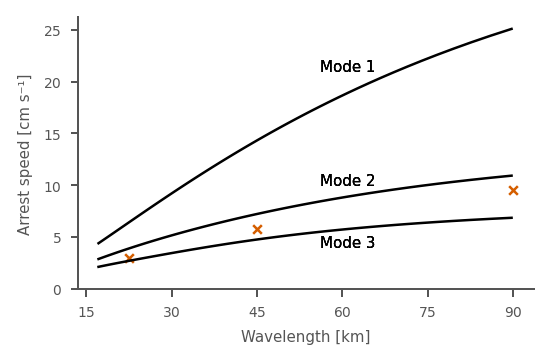

In [23]:
import scipy.io

fig, ax = create_figure("single",
                        #aspect_ratio=0.75
                               )
customize_axis(ax, xzero=False)

for mode, color in zip([1, 2, 3], ["black", "black", "black"]):
    bwaves_data = scipy.io.loadmat(f"../output/processed/wave_comparison/bwavesp_outputs_mode{mode}_full.mat")
    rl = bwaves_data["rl"].flatten()  # wavenumber [rad/cm]
    ws = bwaves_data["ws"].flatten()  # frequency [rad/s]

    k = rl / 0.01                         # rad/cm → rad/m
    lambda_km = 2 * np.pi / k / 1000      # wavelength [km]
    c_phase_cmps = (ws / k) * 100

    ax.plot(lambda_km, c_phase_cmps, color=color)

#ax.set_xlim(0,None)
ax.set_ylim(0,None)
ax.set_xticks([15, 30, 45, 60, 75, 90])


ax.set_xlabel("Wavelength [km]")
ax.set_ylabel("Arrest speed [cm s⁻¹]")

for wl, data in arrest_speed_results.items():
    wl = float(wl)
    retrograde = data["retrograde"]
    ax.scatter(wl, retrograde*1e2, color=colorwheel[2], marker="x", s=12)
    # lower = (retrograde - retrograde_min) * 1e2
    # upper = (retrograde_max - retrograde) * 1e2
    # ax.errorbar(wl, retrograde*1e2, yerr=[[lower], [upper]],
    #             color=colorwheel[2], 
    #             #marker="x", 
    #             capsize=4)
    
    # add text with mode number
    ax.text(56, 21, "Mode 1", color="black")
    ax.text(56, 10, "Mode 2", color="black")
    ax.text(56, 4, "Mode 3", color="black")
    
fig.savefig(figpath+"arrest_speed.pdf", bbox_inches="tight", pad_inches=0.02)

fig.patch.set_alpha(0.0)     # figure background
ax.patch.set_alpha(0.0)      # axes background (optional)
fig.savefig(figpath+"arrest_speed_pres.svg", bbox_inches="tight", pad_inches=0.02, transparent=True)

### Mode structure

We next compare the cross-slope structure of the simulated pressure (constructed from a phase-composite of sea-surface height anomalies) to the corresponding theoretical mode structure from the wave model. The top panel shows the normalized mode structure from the wave calculation, while the bottom panel shows the simulated dynamic pressure anomaly at selected \(x\)-locations.

The figure is saved as `mode_structure.pdf`.


In [24]:
# Load MATLAB file
bwaves_data = scipy.io.loadmat("../output/processed/wave_comparison/bwavesp_outputs_mode2_45km.mat")
x = bwaves_data["x"].flatten()
pp = bwaves_data["pp"].flatten()

mode = xr.open_dataarray(datapath+"wave_comparison/mode_structure.nc")
mode

<xarray.DataArray (time: 512, yC: 90, xC: 90)>
[4147200 values with dtype=float64]
Coordinates:
  * xC       (xC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * yC       (yC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * time     (time) timedelta64[ns] 0 days 00:00:00 ... 63 days 21:00:00

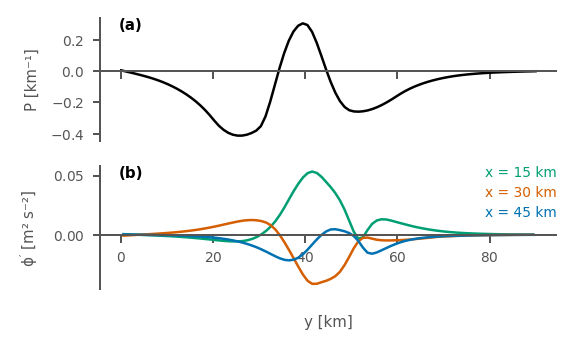

In [25]:
tidx = 30*8

fig, [axt,axb] = create_figure("single", 
                               nrows=2, 
                               sharex =True
                               )

customize_axis(axt, xzero=False)
customize_axis(axb, xzero=False)

ys = mode.yC/1e3

axt.plot(x/1e5, pp*1e5, color="black")  # pp has units cm-1, wan to konvert to units of km-1

for i, xidx in enumerate([15,30,45]):
    modei = mode.isel(time=tidx, xC=xidx)*9.81  # convert to dynamic pressure
    axb.plot(ys, modei, color=colorwheel[i+1], label=f"x = {xidx} km")
    
#axb.legend(loc="upper right", frameon=False, bbox_to_anchor=(1,1.4))
labels = ["x = 15 km", "x = 30 km", "x = 45 km"]
y_start = 1
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel[1:]):
    axb.text(
        1, y,
        label,
        color=color,
        fontsize=5.5,
        transform=axb.transAxes,
        ha="right", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

axb.set_xlabel("y [km]", labelpad=20)

axt.set_ylabel("P [km⁻¹]")  # this is a normalized pressure structure function
axb.set_ylabel(r"$\phi'$ [m² s⁻²]")

# # Shift x-axis tick labels downward
# for label in axb.get_xticklabels():
#     label.set_y(label.get_position()[1] - 17e-4)
fig.align_labels()


axt.text(0.04, 1, "(a)", color="black",
         transform=axt.transAxes,
         va="top", fontweight="bold", fontsize=6)
axb.text(0.04, 1, "(b)", color="black",
         transform=axb.transAxes,
         va="top", fontweight="bold", fontsize=6)


fig.savefig(figpath+"mode_structure.pdf", bbox_inches="tight", pad_inches=0.02)


### Maximum velocity as a function of forcing strength

We lastly quantify how maximum prograde and retrograde speeds scale with forcing amplitude for both forcing periods, evaluated at several depth contours. Markers show individual simulations, and colors indicate depth. This figure highlights whether the response is approximately linear in forcing or exhibits saturation.

The figure is saved as `increasing_forcing.pdf`.

In [26]:
data = xr.open_dataset(datapath+"wave_comparison/forcing_vs_arrest_speeds.nc")

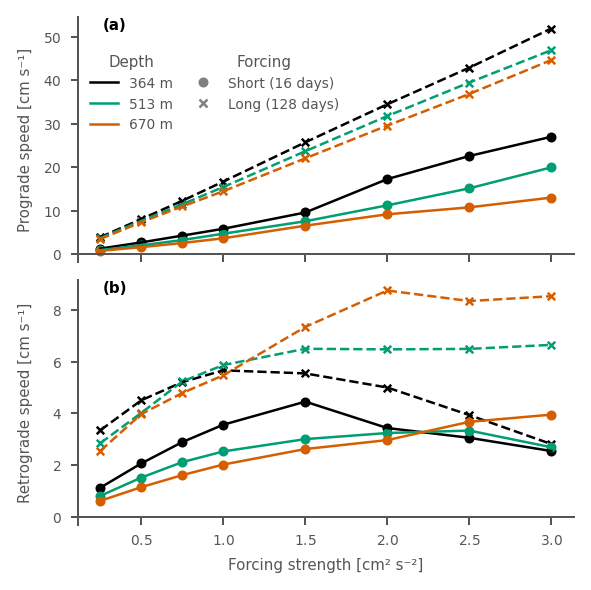

In [27]:
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=get_figure_dimensions(aspect_ratio=1), sharex=True)
fig, [ax1,ax2] = create_figure("single", 
                               aspect_ratio=1,
                               nrows=2, 
                               sharex =True
                               )
customize_axis(ax1, xzero=False)
customize_axis(ax2, xzero=False)

depths = list(data.depth.values)

# --- Plotting ---
for i, depth in enumerate(depths):
    c = colorwheel[i]

    # Prograde
    x_short = data.forcing_strength.sel(period="short")*1e4
    y_short = data.prograde_max.sel(period="short", depth=depth)*1e2
    ax1.plot(x_short, y_short, color=c)
    ax1.scatter(x_short, y_short, color=c, marker="o")

    x_long = data.forcing_strength.sel(period="long")*1e4
    y_long = data.prograde_max.sel(period="long", depth=depth)*1e2
    ax1.plot(x_long, y_long, color=c, ls="--")
    ax1.scatter(x_long, y_long, color=c, marker="x")

    # Retrograde
    y_short = data.retrograde_max.sel(period="short", depth=depth)*1e2
    ax2.plot(x_short, y_short, color=c)
    ax2.scatter(x_short, y_short, color=c, marker="o")

    y_long = data.retrograde_max.sel(period="long", depth=depth)*1e2
    ax2.plot(x_long, y_long, color=c, ls="--")
    ax2.scatter(x_long, y_long, color=c, marker="x")

# --- Legends ---
# Depth legend (colors only)
depth_handles = [
    Line2D([0], [0], color=colorwheel[i], label=f"{int(d)} m")
    for i, d in enumerate(depths)
]

# Forcing legend (symbols only, in grey)
forcing_handles = [
    Line2D([0], [0], marker="o", color="grey", linestyle="None", label="Short (16 days)"),
    Line2D([0], [0], marker="x", color="grey", linestyle="None", label="Long (128 days)"),
]

leg_depths = ax1.legend(handles=depth_handles, title="Depth", 
                        frameon=False, loc="upper left" , bbox_to_anchor=(0, 0.9))
leg_forcing = ax1.legend(handles=forcing_handles, title="Forcing",
                         frameon=False, loc="upper left", bbox_to_anchor=(0.2, 0.9))
ax1.add_artist(leg_depths)

# Labels
ax1.set_ylabel("Prograde speed [cm s⁻¹]")
ax2.set_ylabel("Retrograde speed [cm s⁻¹]")
ax2.set_xlabel("Forcing strength [cm² s⁻²]")

ax2.set_ylim(-0.3, None)

ax1.text(0.05, 1, "(a)", color="black",
         transform=ax1.transAxes,
         va="top", fontweight="bold", fontsize=6)
ax2.text(0.05, 1, "(b)", color="black",
         transform=ax2.transAxes,
         va="top", fontweight="bold", fontsize=6)

fig.align_labels()
fig.tight_layout()
fig.savefig(figpath+"increasing_forcing.pdf", bbox_inches="tight")